In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [6]:
##GEORGIA GA
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Yearly data/Flats' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

##Bands and indices

df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])

df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

##DAYMET data added - yearly averages
##PC:
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)

dm['ident'] = dm['Latitude']/dm['Longitude']

##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(columns={'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad', \
                        'tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp'})

##Loading elevation data
elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Point_elevation/DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)

## drop rows which have same lat and long and keep latest entry
dfx = elev_10m.drop_duplicates(
  subset = ['Latitude', 'Longitude'],
  keep = 'last').reset_index(drop = True)

dfx = dfx[['Elevation', 'Latitude', 'Longitude']]
dfx['ident'] = dfx['Latitude']/dfx['Longitude']

df['ident'] = df['Latitude']/df['Longitude'] 

##Merging elevation point data with band dataset prior to model development
df0 = pd.merge(df, dfx, on = 'ident')
df0_sn = pd.merge(df0, dm2)
df1 = pd.merge(df0_sn, dm)

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here
df1 = df1[(df1['flats'] < 0.1) & (df1['flats'] > -0.1)] ##Increases NRMSE by 0.003, but seems to be a better fit


from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]

yargs=df1['Plant_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test - NOT NEEDED IN IMPLEMENTATION?
# # Pipeline example:
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

Mean Absolute Error: 253.8086762347206
Mean Squared Error: 154016.65092239095
Root Mean Squared Error: 392.449552073118
The r squared is: 0.31052349214199715
testing r2 is: 0.31052349214199715
training r2 is: 0.9170795170468004
NRMSE is: 0.13158320885463232


In [9]:
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Yearly point extraction data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') 
df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4']))
df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df = df.drop(columns=['latitude','longitude'])
df['ident'] = df['Latitude'] / df['Longitude'] + df['Year'] 

##DAYMET data
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/VA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)
dm.rename(columns={'site_id':'siteName'}, inplace=True)
dm = dm.drop(columns=['latitude','longitude'])
dm['ident'] = dm['Latitude'] / dm['Longitude'] + dm['Year']

##TBD: Seasonal averages/growing season (defined as between 3/1 and 10/31)

##Loading elevation data
elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Point elevation/VA_DEM_vals_10m.csv')
elev_10m.rename(columns={'first':'Elevation'}, inplace=True)
elev_10m.rename(columns={'site_id':'siteName'}, inplace=True)
elev_10m['ident'] = elev_10m['Latitude'] / elev_10m['Longitude'] + elev_10m['Year']

##Merging daymet, elevation, and flats data
df['dropident'] = df['Latitude']/df['Longitude']*df['Year']+df['liveMass']
dm['dropident'] = dm['Latitude']/dm['Longitude']*dm['Year']+dm['liveMass']
elev_10m['dropident'] = elev_10m['Latitude']/elev_10m['Longitude']*elev_10m['Year']+elev_10m['liveMass']

df0 = pd.merge(df, dm, on = ['dropident'], how = 'left')

df0['dropident'] = df0['Latitude_x']/df0['Longitude_x']*df0['Year_x']+df0['liveMass_x']
print(len(df0['dropident']))
df0 = df0.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)
print(len(df0['dropident']))

##Merge with elevation
df1 = pd.merge(df0, elev_10m, on = ['dropident'], how = 'left')

df1['dropident'] = df1['Latitude_x']/df1['Longitude_x']*df1['Year_x']+df1['liveMass_x']
print(len(df1['dropident']))
df1 = df1.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)
print(len(df1['dropident']))

##THIS NEEDS TO BE 0
print('df0 biomass diff is: '+str(sum(df0['liveMass_x'] - df0['liveMass_y'])))
print('df1 biomass diff (x-y) is: '+str(sum(df1['liveMass_x'] - df1['liveMass_y'])))
print('df1 biomass diff (x-z) is: '+str(sum(df1['liveMass_x'] - df1['liveMass'])))
# df1.rename(columns={'liveMass_x':'liveMass'}, inplace=True)

print("biomass measurements: " + str(len(df1['liveMass'])))
print(len(df1['Elevation'].unique()))

df1 = df1.drop(columns = ['latitude', 'longitude']) ##lower case ones are the older values

##Some more data massaging
df1 = df1[df1['ndvi'].notna()]
df1 = df1[df1['liveMass'].notna()]
df1 = df1[df1['Latitude'].notna()]
df1 = df1[(df1['flats'] < 0.1)] ##Double check

##Group df1 and average (midpoint) the replicates (a/b)
df_temp=df1.copy()

df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
    {
        'liveMass':[np.mean, np.size],'ndvi':[np.mean],'nd_swir2_r':[np.mean],'nd_swir2_nir':[np.mean],'nd_g_b':[np.mean],
        'nd_r_g':[np.mean],'wdrvi5':[np.mean],'savi':[np.mean],'Elevation':[np.mean],'prcp':[np.mean],'dayl':[np.mean],
        'tmax':[np.mean],'tmin':[np.mean],'srad':[np.mean],'vp':[np.mean]
    }
)

df_temp.columns = [
    'Year','locationID','Transect','Latitude','Longitude','liveMass','N','ndvi','nd_swir2_r','nd_swir2_nir', 'nd_g_b', 
    'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl','tmax','tmin','srad','vp'
]

# display(df_temp)

##Machine learning
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

df1 = df_temp ##Therein the rub! COMMENT OUT if you do not want to group replicates
va_df1 = df_temp

print("biomass measurements: " + str(len(df1['liveMass'])))

1900
1846
1864
1846
df0 biomass diff is: 0.0
df1 biomass diff (x-y) is: 0.0
df1 biomass diff (x-z) is: 0.0
biomass measurements: 1846
153
biomass measurements: 611


Mean Absolute Error: 590.8974922869614
Mean Squared Error: 470234.44618498994
Root Mean Squared Error: 685.7364261762605
The r squared is: -2.4286074145505956
-2.4286074145505956
NRMSE is: 0.26952505509553365


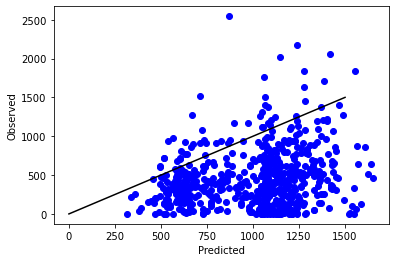

test data correlation coefficient is: 0.5916112515686084


In [10]:
##Running the GA model on VA data

##Really, really needs improvement

va_xargs = va_df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]

va_yargs = va_df1['liveMass']

va_pred=pipe.predict(va_xargs)

print('Mean Absolute Error:', metrics.mean_absolute_error(va_yargs, va_pred))
print('Mean Squared Error:', metrics.mean_squared_error(va_yargs, va_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(va_yargs, va_pred)))
r_square = metrics.r2_score(va_yargs, va_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(va_yargs, va_pred))/np.ptp(va_yargs)))


plt.scatter(va_pred, va_yargs, color = 'blue')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 1500], [0, 1500], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

Mean Absolute Error: 308.46658376118245
Mean Squared Error: 254019.18984042402
Root Mean Squared Error: 504.0031645142955
The r squared is: 0.4058333576496387
0.4058333576496387
testing r2 is: 0.4058333576496387
training r2 is: 0.9053156419748772
NRMSE is: 0.10966107206825913
MEAN BASELINE:
Mean Absolute Error: 433.95318317492706
Root Mean Squared Error: 656.8091950621074


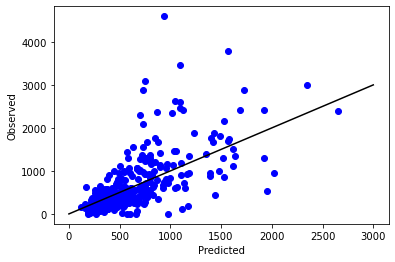

test data correlation coefficient is: 0.6421627635712808
train data correlation coefficient is: 0.9633352071819892


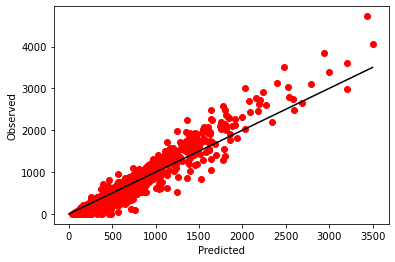

In [19]:
##Combining the datasets

combined_df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Comparisons/gavacombined.csv')

combined_df = combined_df[combined_df['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
combined_df = combined_df[combined_df['prcp'].notna()] ##CAREFUL; added 7/11/22
combined_df = combined_df[combined_df['Species_Code'] == 'A1'] ##careful here

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xargs=combined_df[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'swe','vp']]

##From linear regression results: maybe remove nd_swir2_nir/r from feature list? May improve prediction results. 
##Also: nd_r_g, dayl, and vp all can be removed. Seasonal average vs. yearly average will probably be a choice.

#'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp'

##Include lag variables (e.g. lag ndvi), precip, temp, more

##ELEVATION NEEDS TO BE TRIPLE-CHECKED AT EACH PLOT TO MAKE SURE VALUES CORRESPOND

yargs=combined_df['Plant_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

# # Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

plt.scatter(y_pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))


In [20]:
combined_df

,B1,B2,B3,B4,B5,B6,B7,system:index,Site,Species_Code,...,sn_vp,Latitude,Longitude,dayl,prcp,srad,swe,tmax,tmin,vp
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0,1,A1,...,1776.901489,31.538627,-81.422539,43200.08594,2.568438,342.593597,0.000000,25.048056,14.132274,1776.901489
1,0.0263,0.0404,0.0351,0.0745,0.0697,0.2883,0.0448,0,1,A1,...,1762.035522,31.538627,-81.422539,43220.08203,2.596593,342.510712,0.000000,25.575659,14.795082,1762.035522
3,0.0344,0.0429,0.0374,0.0798,0.0649,0.2951,0.0362,0,1,A1,...,1778.461426,31.538627,-81.422539,43200.08594,3.297945,340.148438,0.000000,25.406548,14.338548,1778.461426
4,0.0240,0.0361,0.0321,0.0872,0.0559,0.2947,0.0309,0,1,A1,...,1799.670776,31.538627,-81.422539,43220.08203,4.259862,338.359924,0.000000,25.079752,14.206429,1799.670776
5,0.0598,0.0626,0.0610,0.1112,0.0979,0.2968,0.0613,0,1,A1,...,1683.812134,31.538627,-81.422539,43220.08203,2.628269,351.314453,0.000000,26.066071,14.187940,1683.812134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3303,0.0532,0.0697,0.0731,0.1887,0.2318,0.2994,0.1283,11,N_Brownsville,A1,...,NaN,37.468043,-75.822928,43225.22656,2.652720,317.546905,0.000000,20.071978,10.639917,1469.800293
3304,0.0461,0.0688,0.0698,0.2359,0.2200,0.2990,0.1088,11,N_Brownsville,A1,...,NaN,37.468043,-75.822928,43225.22656,3.918159,302.312927,0.000000,19.204807,10.557253,1459.927246
3305,0.0583,0.0650,0.0623,0.2119,0.2058,0.2973,0.0990,11,N_Brownsville,A1,...,NaN,37.468043,-75.822928,43225.22656,2.801017,312.438080,0.540165,19.641483,10.664945,1483.516724
3306,0.0377,0.0556,0.0542,0.2257,0.1826,0.2964,0.0737,11,N_Brownsville,A1,...,NaN,37.468043,-75.822928,43225.22656,2.758736,313.937012,0.000000,20.372116,11.170687,1494.422729


In [1]:
# ##Running the GA model on VA data

# ##Really, really needs improvement

# va_df1 = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Comparisons/va_df1.csv')

# va_xargs = va_df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
#            'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]

# va_yargs = va_df1['liveMass']

# va_pred=pipe.predict(va_xargs)

# print('Mean Absolute Error:', metrics.mean_absolute_error(va_yargs, va_pred))
# print('Mean Squared Error:', metrics.mean_squared_error(va_yargs, va_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(va_yargs, va_pred)))
# r_square = metrics.r2_score(va_yargs, va_pred)
# print("The r squared is: " + str(r_square))
# print(r_square)
# print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(va_yargs, va_pred))/np.ptp(va_yargs)))


# plt.scatter(va_pred, va_yargs, color = 'blue')
# plt.xlabel("Predicted")
# plt.ylabel("Observed")
# plt.plot([0, 1500], [0, 1500], 'k-')
# plt.show()

# print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))